# 1D time series analysis

https://www.geeksforgeeks.org/time-series-analysis-and-forecasting

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
series = pd.read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True)

In [4]:
series_m = series['Temp'].resample('ME').mean().dropna()
# series_w = series['Temp'].resample('W').mean().dropna()

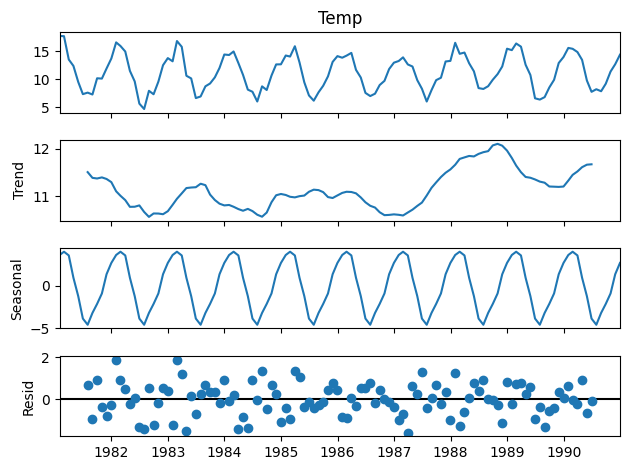

In [5]:
# decomposition=seasonal_decompose(series_w,model='additive',period=52)
decomposition=seasonal_decompose(series_m,model='additive',period=12)
decomposition.plot()
plt.show()

### Prep validation

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
# tscv = TimeSeriesSplit(n_splits=3, test_size=52)
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

## Test approaches

### Sarimax

In [8]:
maes = []

for train, test in tscv.split(series_m):
    model = SARIMAX(series_m[train], order=(1,0,2),seasonal_order=(1,0,1,12)).fit(disp=False)
    
    forecast = model.get_forecast(steps=3)
    resid=series_m[test[:3]]-forecast.predicted_mean
    mae=resid.abs().mean()
    maes.append(mae)
    
    tscv_inner = TimeSeriesSplit(n_splits=3, test_size=3)
    for x, y in tscv_inner.split(test):
        updated_model = model.extend(series_m[test[x]], fit_params=None)
        forecast = updated_model.get_forecast(steps=3)
        resid=series_m[test[y]]-forecast.predicted_mean
        mae=resid.abs().mean()
        maes.append(mae)

In [9]:
sum(maes) / len(maes)

0.8177598551899594

In [10]:
maes

[1.3462320346415293,
 1.0486780180663768,
 1.0457751559402058,
 1.0108523619274632,
 0.7605826411960207,
 0.998385400620867,
 1.308135668193619,
 0.3340641858816582,
 0.36442594426138913,
 0.6245629949664732,
 0.5856717397978729,
 0.3857521167860393]

### AdaBoost - last few samples

In [11]:
from sklearn.ensemble import AdaBoostRegressor

In [12]:
n_lags = 12
data = {
    f"lag_{i}": series_m.shift(i) for i in range(1, n_lags + 1)
}
# Combine the lagged columns into a DataFrame
df = pd.DataFrame(data)

In [13]:
df[11:]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,
1981-12-31,11.890000,10.087097,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000,17.678571,17.712903,NaN
1982-01-31,13.680645,11.890000,10.087097,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000,17.678571,17.712903
1982-02-28,16.567742,13.680645,11.890000,10.087097,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000,17.678571
1982-03-31,15.921429,16.567742,13.680645,11.890000,10.087097,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000
1982-04-30,14.935484,15.921429,16.567742,13.680645,11.890000,10.087097,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667
...,...,...,...,...,...,...,...,...,...,...,...,...
1990-08-31,8.183871,7.720000,9.748387,13.433333,14.835484,15.417857,15.577419,13.951613,12.876667,9.867742,8.486667,6.770968
1990-09-30,7.825806,8.183871,7.720000,9.748387,13.433333,14.835484,15.417857,15.577419,13.951613,12.876667,9.867742,8.486667
1990-10-31,9.166667,7.825806,8.183871,7.720000,9.748387,13.433333,14.835484,15.417857,15.577419,13.951613,12.876667,9.867742


In [14]:
model1 = AdaBoostRegressor(n_estimators=200)
model2 = AdaBoostRegressor(n_estimators=200)
model3 = AdaBoostRegressor(n_estimators=200)

In [15]:
df.iloc[train]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,
1981-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-02-28,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-03-31,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-05-31,12.356667,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1989-08-31,6.332258,6.560000,10.725806,12.563333,15.803226,16.371429,15.180645,15.436667,12.253333,10.890323,9.883333,8.725806
1989-09-30,6.770968,6.332258,6.560000,10.725806,12.563333,15.803226,16.371429,15.180645,15.436667,12.253333,10.890323,9.883333
1989-10-31,8.486667,6.770968,6.332258,6.560000,10.725806,12.563333,15.803226,16.371429,15.180645,15.436667,12.253333,10.890323


In [16]:
maes = []

for train, test in tscv.split(series_m):
    model1 = AdaBoostRegressor(n_estimators=200).fit(df.iloc[train][12:], series_m[train][12:])
    model2 = AdaBoostRegressor(n_estimators=200).fit(df.iloc[train][12:-1], series_m[train][13:])
    model3 = AdaBoostRegressor(n_estimators=200).fit(df.iloc[train][12:-2], series_m[train][14:])
    
    forecast1 = model1.predict(df.iloc[test])
    forecast2 = model2.predict(df.iloc[test])
    forecast3 = model3.predict(df.iloc[test])
    
    resid1=series_m[test]-forecast1
    resid2=series_m[test[1:]]-forecast2[:-1]
    resid3=series_m[test[2:]]-forecast3[:-2]
    
    mae=resid1.abs().mean()
    maes.append(mae)
    mae=resid2.abs().mean()
    maes.append(mae)
    mae=resid3.abs().mean()
    maes.append(mae)
    

In [17]:
sum(maes) / len(maes)

0.9910573219209543

In [18]:
maes

[1.172860072822438,
 1.2318896352590991,
 1.191317133162228,
 0.9662132537330271,
 0.9330463275828386,
 0.9764365745407236,
 0.7863510601694602,
 0.754824202225597,
 0.9065776377931762]

### LSTM

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_size, output_size):
        self.series = torch.tensor(series.values, dtype=torch.float32)
        self.input_size = input_size
        self.output_size = output_size

    def __len__(self):
        return len(self.series) - self.input_size - self.output_size + 1

    def __getitem__(self, index):
        x = self.series[index : index + self.input_size]
        y = self.series[index + self.input_size : index + self.input_size + self.output_size]
        return x, y

# Parameters
input_size = 12
output_size = 3

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use the last LSTM output
        return output

# Hyperparameters
hidden_size = 24
num_layers = 2

In [33]:
tscv_lstm = TimeSeriesSplit(n_splits=3, test_size=12+input_size, gap=-input_size)

maes = []

for train, test in tscv_lstm.split(series_m):
    dataset = TimeSeriesDataset(series_m[train], input_size, output_size)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

            
    dataset = TimeSeriesDataset(series_m[test], input_size, output_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    predictions = []
    for x, y in dataloader:
        a = model(x)
        predictions.append(a.detach().numpy()[0])

    p1 = [x[0] for x in predictions]
    p2 = [x[1] for x in predictions]
    p3 = [x[2] for x in predictions]

    r1 = series_m[test][input_size:-2] - p1
    r2 = series_m[test][input_size+1:-1] - p2
    r3 = series_m[test][input_size+2:] - p3

    mae = (r1.abs().mean() + r2.abs().mean() + r3.abs().mean()) / 3
    maes.append(mae)

In [35]:
sum(maes) / len(maes)

1.0867668795847611

In [36]:
maes

[1.0171204340339501, 1.6135620257750443, 0.6296181789452885]

### Conv1D

In [37]:
# 1D Convolutional Neural Network Model
class CNN1DModel(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding="same")
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(output_size=1)  # Aggregate across the input size
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, input_size]
        x = self.conv1(x)   # Apply 1D convolution
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)  # Pool and squeeze: [batch_size, num_filters]
        x = self.fc(x)       # Fully connected layer: [batch_size, output_size]
        return x

# Hyperparameters
num_filters = 32
kernel_size = 3

In [41]:
# Create TimeSeriesSplit object
tscv_cnn = TimeSeriesSplit(n_splits=3, test_size=12 + input_size, gap=input_size)

maes = []

for train, test in tscv_cnn.split(series_m):
    # Dataset and DataLoader
    dataset = TimeSeriesDataset(series_m.iloc[train], input_size, output_size)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize CNN Model
    model = CNN1DModel(input_size, num_filters, kernel_size, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 5000
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

    # Evaluate on test set
    dataset = TimeSeriesDataset(series_m.iloc[test], input_size, output_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    predictions = []
    for x, y in dataloader:
        a = model(x)
        predictions.append(a.detach().numpy()[0])

    # Extract step-wise predictions
    p1 = [x[0] for x in predictions]
    p2 = [x[1] for x in predictions]
    p3 = [x[2] for x in predictions]

    # Residuals and MAE
    r1 = series_m.iloc[test[input_size:-2]] - p1
    r2 = series_m.iloc[test[input_size+1:-1]] - p2
    r3 = series_m.iloc[test[input_size+2:]] - p3

    mae = (r1.abs().mean() + r2.abs().mean() + r3.abs().mean()) / 3
    maes.append(mae)

Epoch 100/5000, Loss: 11.5406
Epoch 200/5000, Loss: 11.8673
Epoch 300/5000, Loss: 11.2635
Epoch 400/5000, Loss: 10.3560
Epoch 500/5000, Loss: 9.4628
Epoch 600/5000, Loss: 8.0356
Epoch 700/5000, Loss: 6.3933
Epoch 800/5000, Loss: 5.8186
Epoch 900/5000, Loss: 5.1881
Epoch 1000/5000, Loss: 4.2262
Epoch 1100/5000, Loss: 3.8192
Epoch 1200/5000, Loss: 3.4286
Epoch 1300/5000, Loss: 3.2947
Epoch 1400/5000, Loss: 2.6627
Epoch 1500/5000, Loss: 2.6415
Epoch 1600/5000, Loss: 2.3590
Epoch 1700/5000, Loss: 2.0196
Epoch 1800/5000, Loss: 2.1103
Epoch 1900/5000, Loss: 1.8378
Epoch 2000/5000, Loss: 1.8944
Epoch 2100/5000, Loss: 1.3385
Epoch 2200/5000, Loss: 1.6417
Epoch 2300/5000, Loss: 1.6884
Epoch 2400/5000, Loss: 1.6482
Epoch 2500/5000, Loss: 1.5347
Epoch 2600/5000, Loss: 1.3608
Epoch 2700/5000, Loss: 1.3083
Epoch 2800/5000, Loss: 1.5349
Epoch 2900/5000, Loss: 1.3235
Epoch 3000/5000, Loss: 1.3713
Epoch 3100/5000, Loss: 1.2989
Epoch 3200/5000, Loss: 1.3014
Epoch 3300/5000, Loss: 1.3503
Epoch 3400/5000

In [42]:
sum(maes) / len(maes)

1.078812238514425

In [43]:
maes

[0.9960781285285459, 1.1601334835114254, 1.0802251035033037]

### Prophet

In [65]:
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [70]:
series_m_p = series_m.copy()
series_m_p = pd.DataFrame({'ds':series_m_p.index, 'y':series_m_p.values})


In [100]:
# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=12, test_size=3)  # Adjust test size as needed

maes = []

for train_idx, test_idx in tscv.split(series_m_p):
    # Split data into training and test sets
    train_data = series_m_p.iloc[train_idx]
    test_data = series_m_p.iloc[test_idx]

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(train_data)

    # Forecast using the Prophet model
    forecast = model.predict(future)

    # Extract test period predictions
    test_predictions = model.predict(test_data[['ds']])['yhat']

    # Calculate MAE for the test set
    mae = np.mean(np.abs(test_data['y'].values - test_predictions))
    maes.append(mae)


10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing
10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing
10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:22 - cmdstanpy - INFO - Chain [1] done processing
10:38:22 - cmdstanpy - INFO - Chain [1] start processing
10:38:22 - cmdstanpy - INFO - Chain [1] done processing
10:38:22 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:23 - cmdstanpy - INFO - Chain [1]

In [101]:
maes

[1.603530821248593,
 1.5166200272035255,
 1.182225196175396,
 0.8162213032181457,
 0.7557259291401989,
 0.6895492817630698,
 1.3748483836236047,
 0.389239118908509,
 0.23170178641506212,
 0.6290255532436166,
 0.7045259766268851,
 0.3803257404621115]

In [102]:
sum(maes)/len(maes)

0.8561282598357266